# Analyzing Biodiversity Intactness Index change in Phoenix, Arizona
### EDS 220 Final Project
##### Author: Ava Robillard
##### GitHub repository: https://github.com/avarobillard/phoenix-biodiversity

### Purpose:
The Phoenix metropolitan area, located in Maricopa County, experienced significant increases in urban sprawl between the years of 2017 and 2020. This analysis serves to understand the implications for biodiveristy and the health of surrounding ecosystems using the change in Biodiversity Intactness Index between that time period.

### Analysis highlights:

- Geospatial data exploration and wrangling with `geopandas`
- Accessing data using a STAC (SpatioTemporal Asset Catalog) API
- NetCDF data exploration and wrangling with `xarray` and `rioxarray`
- Mapping of vector and raster data and customization with `matplotlib`

### About the data:

In this notebook we use two datasets:

1) The data used for the geographic extent of the Phoenix area was the Phoenix Subdivision polygon, retrieved from the TIGER/Line Census County Subdivision shapefiles for Arizona available through the [U.S Census Bureau's data catalog](https://catalog.data.gov/dataset/tiger-line-shapefile-current-state-arizona-county-subdivision). The data is able to be filtered and includes names of county subdivisions, such as Phoenix, as well as county FIPS codes, such as for Maricopa County.

2) The Biodiversity Intactness Index (BII) Time Series used for this analysis is retrieved from the  io-biodiversity collection from the [Microsoft Planetary Computer STAC catalog](https://planetarycomputer.microsoft.com/dataset/io-biodiversity). The rasters contain 100-meter resolution estimates of biodiversity intactness, which is estimated from two metrics: Abundance and Compositional Similarity of species. We will specifically be searching the catalog for rasters from 2017 and 2020 covering the Pheonix subdivision. 

### References 

U.S. Census Bureau, Geography Division. (2024). TIGER/Line shapefile, current, state, Arizona, county subdivision (Publication year 2024; created 2024-10; updated 2024-10) [Data set]. U.S. Department of Commerce. Accessed December 5, 2025, from https://catalog.data.gov/dataset/tiger-line-shapefile-current-state-arizona-county-subdivision

Impact Observatory. (2017-2020). Biodiversity Inactness[io-biodiversity]. Microsoft Planetary Computer STAC catalog. Accessed December 5, 2025, from https://planetarycomputer.microsoft.com/dataset/io-biodiversity#overview 







In [249]:
# Load packages
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rioxr
import contextily as ctx
import matplotlib.patches as mpatches

from pystac_client import Client # to access STAC catalogs
import planetary_computer # to sign items from the MPC STAC catalog
from IPython.display import Image # to nicely display image

### 1. Import and explore Phoenix Subdivision Shapefile

In [2]:
# Import Phoenix Subdivision Shapefile
fp = os.path.join('data', 'tl_2024_04_cousub', 'tl_2024_04_cousub.shp')
az = gpd.read_file(fp)

In [3]:
# Display first few rows of Arizona GeoDataFrame
az.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,0600000US0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,S,12231962349,44576380,+35.1066122,-111.3662507,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,0600000US0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,S,7228864156,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."
2,04,005,91683,01934950,0400591683,0600000US0400591683,Hualapai,Hualapai CCD,22,Z5,G4040,S,2342313339,3772690,+35.9271665,-113.1170408,"POLYGON ((-113.35416 36.04097, -113.35416 36.0..."
3,04,023,92295,01934961,0402392295,0600000US0402392295,Nogales,Nogales CCD,22,Z5,G4040,S,1762339489,2382710,+31.4956020,-111.0171332,"POLYGON ((-111.36692 31.52136, -111.36316 31.5..."
4,04,023,92550,01934966,0402392550,0600000US0402392550,Patagonia,Patagonia CCD,22,Z5,G4040,S,1439560139,685527,+31.5664619,-110.6410279,"POLYGON ((-110.96273 31.68695, -110.96251 31.6..."


In [4]:
# Check the CRS
print(az.crs)

EPSG:4269


In [5]:
# Examine CRS details
print('Ellipsoid:', az.crs.ellipsoid)
print('Datum:', az.crs.datum)
print('Is geographic?:', az.crs.is_geographic)
print('Is projected?:', az.crs.is_projected)

Ellipsoid: GRS 1980
Datum: North American Datum 1983
Is geographic?: True
Is projected?: False


In [6]:
# Print unique county codes
az['COUNTYFP'].unique()

array(['005', '023', '011', '013', '019', '017', '015', '007', '003',
       '025', '021', '001', '027', '009', '012'], dtype=object)

In [7]:
# Print unique county subdivsion names 
az['NAME'].unique()

array(['Flagstaff', 'Kaibab Plateau', 'Hualapai', 'Nogales', 'Patagonia',
       'Hopi', 'Tuba City', 'Clifton', 'Duncan', 'Chandler', 'Phoenix',
       'Tonto National Forest', 'Gila Bend', 'Wickenburg', 'Deer Valley',
       'Buckeye', 'St. Johns', 'Salt River', 'Tucson', 'Arivaca',
       'Indian Wells', 'Winslow-Holbrook', 'Snowflake', 'Kayenta',
       'Lake Havasu City', 'Fort Apache', 'Bisbee', 'Bowie', 'Willcox',
       'North Mohave', 'Kingman', 'Bullhead City', 'Congress',
       'Mingus Mountain', 'Florence', 'North Pinal', 'San Manuel', 'Eloy',
       'Chinle', 'Sweetwater', 'Fort Defiance', 'Dennehotso', 'Puerco',
       'Ash Fork', 'Cordes Lakes-Mayer', 'Camp Verde-Sedona', 'Prescott',
       'Piñon', 'Payson', 'Winkelman', 'Globe-Miami', 'Tonto Basin',
       'Gila River', 'Casa Grande', 'Maricopa-Stanfield',
       "Tohono O'odham Nation", 'Coolidge', 'Ajo', 'Marana', 'Somerton',
       'Bonita-Klondyke', 'Eagar-Springerville', 'San Carlos',
       'Havasupai', 'William

In [ ]:
# continue data exploration!

We see that the CRS is geographic, so we will likely need to change this for our analysis. The 'COUNTYFP' column contains the FIPS codes for each county in Arizona. Maricopa county's FIPS code is 013. The 'NAME' column contains county subdivision names, including Phoenix which we will need to filter to... explain more here

In [216]:
# Convert to projected CRS for plotting
az = az.to_crs(epsg=3857)

In [217]:
# Filter to Maricopa County 
maricopa = az[az['COUNTYFP'] == '013']

# Use the 'NAME' column to filter to Phoenix county.
phoenix = maricopa[maricopa['NAME'] == "Phoenix"]

assert phoenix.crs == az.crs

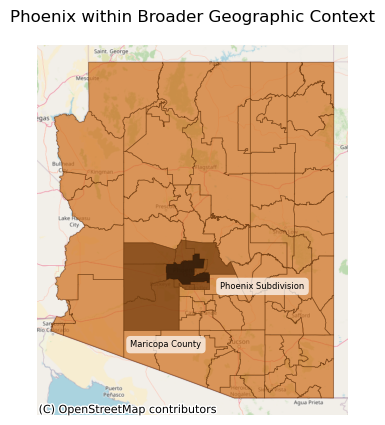

In [229]:
# Plot AZ
fig, ax = plt.subplots()

az.plot(ax=ax,
             alpha=0.7,
             color='#CF6E1B',
             edgecolor = "#6E3C12",
             linewidth = 0.5)

maricopa.plot(ax=ax,
             alpha=0.7,
             color='#703A0C',
             linewidth = 3)

phoenix.plot(ax=ax,
             alpha=0.7,
             color='#1A0D03',
             linewidth = 3)

# Add basemap using contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs = az.crs)

# Add county label (Maricopa)
ax.text(maricopa.geometry.centroid.iloc[0].x - 80000,
        maricopa.geometry.centroid.iloc[0].y - 140000,
        "Maricopa County",
        color="black",
        fontsize=6,
        ha='center',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0.5, boxstyle="round"))

# Add subdivision label (Phoenix)
ax.text(phoenix.geometry.centroid.iloc[0].x + 170000,
        phoenix.geometry.centroid.iloc[0].y - 40000,
        "Phoenix Subdivision",
        color="black",
        fontsize=6,
        ha='center',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0.5, boxstyle="round"))


ax.axis('off')

# Add title
plt.title('Phoenix within Broader Geographic Context')

plt.show()


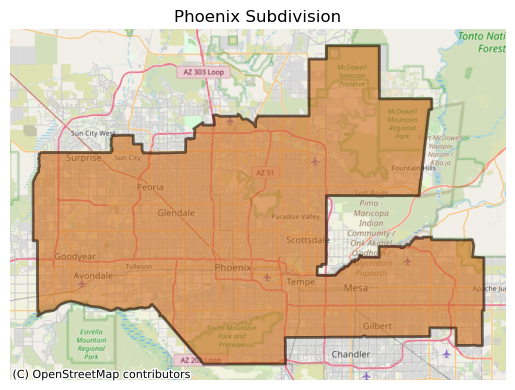

In [223]:
# Plot Phoenix alone
fig, ax = plt.subplots()
phoenix.plot(ax=ax,
             alpha=0.6,
             color='#CF6E1B',
             edgecolor = '#1A0D03',
             linewidth = 2)

# Add basemap using contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs = az.crs)

ax.axis('off')

plt.title("Phoenix Subdivision")

plt.show()

### 2. Access and explore Biodiversity Intactness Index

The Biodiversity Intactness Index is located within the io-biodiversity collection, which can be accessed from the Microsoft Planetary Computer STAC catalog. Each collection within the catalog has multiple items, which have properties (metadata) and assests (links to the data). Because we need the BII of the Phoenix area specifically during the years of 2017 and 2020, we will need to search the io-biodiversity collection using a specifc time range and bounding box.

In [197]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [198]:
# Access io-biodiversity collection
io_bio_collection = catalog.get_child('io-biodiversity')
io_bio_collection

<CollectionClient id=io-biodiversity>

In [199]:
# Phoenix bounding box 
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# Temporal range of interest
time_range = "2017-01-01/2020-01-01"

# Catalog search
search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox,
    datetime = time_range
)
search

In [200]:
# Check how many items are in search results
items = search.item_collection()
len(items)

4

These are the four years of data we requested, 2017-2020.

In [201]:
# Print dates here instead!
items

In [202]:
# Get first item in the catalog search for 2020
item2020 = items[0]

# Get third item in the catalog search for 2017
item2017 = items[3]

In [203]:
# Examine more information about each asset in the item
for key in item2017.assets.keys():
    print(key, '--', item2017.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


We want to access the data asset within each item using `open_rasterio`. 

In [204]:
# Open 2017 BII over Phoenix
bii2017 = rioxr.open_rasterio(item2017.assets['data'].href).squeeze().drop_vars('band')
bii2017

<xarray.DataArray (y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [205]:
# Open 2020 BII over Phoenix
bii2020 = rioxr.open_rasterio(item2020.assets['data'].href).squeeze().drop_vars('band')
bii2020

<xarray.DataArray (y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [237]:
# Match CRSs and verify update 
phoenix = phoenix.to_crs(bii2017.rio.crs)
assert phoenix.crs == bii2017.rio.crs
assert phoenix.crs == bii2020.rio.crs

Next, we need to clip the data to the same extent as our Phoenix boundary data.

In [207]:
# Clip each year to Phoenix boundary
bii2017_clip = (bii2017.rio.clip_box(*phoenix.total_bounds).rio.clip(phoenix.geometry))
bii2020_clip = (bii2020.rio.clip_box(*phoenix.total_bounds).rio.clip(phoenix.geometry))

In [209]:
# Create rasters of area where BII is at least 0.75- creates rasters filled with booleans 
# 2017
bii2017_above = bii2017_clip >= 0.75

# 2020
bii2020_above = bii2020_clip >= 0.75

# Percentage of area
biipercent_2017 = (bii2017_above.sum()/bii2017_clip.count()) * 100
biipercent_2020 = (bii2020_above.sum()/bii2020_clip.count()) * 100

print(f"{biipercent_2017:.2f}% of area within the Phoenix subdivision with a BII of at least 0.75")
print(biipercent_2017)
print(biipercent_2020)

7.13% of area within the Phoenix subdivision with a BII of at least 0.75
<xarray.DataArray ()> Size: 8B
array(7.12531075)
Coordinates:
    spatial_ref  int64 8B 0
<xarray.DataArray ()> Size: 8B
array(6.49140522)
Coordinates:
    spatial_ref  int64 8B 0


In [210]:
# Find pixels that changed value between 2017 and 2020
bii_loss = bii2017_above & (~bii2020_above)
bii_loss = bii_loss.where(bii_loss, np.nan)

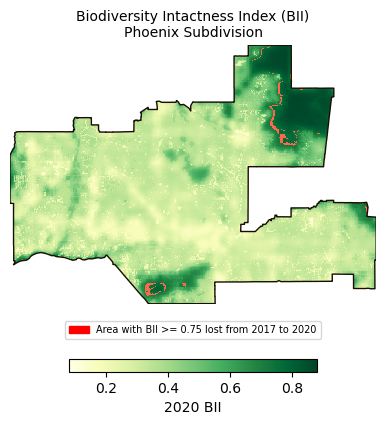

In [267]:
# create visualization!!
# Plot Phoenix alone
fig, ax = plt.subplots()

bii2020_clip.plot(ax=ax,
                  cmap = "YlGn",
                  cbar_kwargs = {'location':'bottom',
                                  'label':'2020 BII',
                                  'shrink':0.5})

bii_loss.plot(ax=ax,
              cmap = "Reds",
              add_colorbar = False)


phoenix.plot(ax=ax, 
             color = 'none',
             edgecolor = '#1A0D03')

# Add legend for loss instead of cmap- the value is just 1
loss_patch = mpatches.Patch(color='red',
                            label='Area with BII >= 0.75 lost from 2017 to 2020')
ax.legend(handles=[loss_patch],
           loc='center',
           bbox_to_anchor=(0.5, -0.1),
           fontsize=7)

ax.axis('off')

plt.title('Biodiversity Intactness Index (BII)\nPhoenix Subdivision', size =10)

plt.show()

## Interpretation